### HAM 10000

* [Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)

* [Original Paper](https://www.nature.com/articles/sdata2018161)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import process_labels, split_data
from src.classifiers_base import preprocess_df

from transformers import BertTokenizer

from src.multimodal_data_loader import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_base import train_early_fusion, train_late_fusion

In [2]:
PATH = 'datasets/ham10000/'

In [3]:
text_path = os.path.join(PATH, 'labels.csv')
images_path = os.path.join(PATH, 'images')

## Get data

In [4]:
df = pd.read_csv(text_path)
df

,image_id,dx,text,split
0,ISIC_0033319,nv,Patient diagnosed via histo. Age: 35 years. Se...,train
1,ISIC_0030823,nv,Patient diagnosed via follow_up. Age: 40 years...,train
2,ISIC_0028730,akiec,Patient diagnosed via histo. Age: 65 years. Se...,train
3,ISIC_0027299,nv,Patient diagnosed via follow_up. Age: 40 years...,train
4,ISIC_0032444,nv,Patient diagnosed via histo. Age: 65 years. Se...,train
...,...,...,...,...
10010,ISIC_0034116,nv,Patient diagnosed via histo. Age: 35 years. Se...,test
10011,ISIC_0026453,bcc,Patient diagnosed via histo. Age: 55 years. Se...,test
10012,ISIC_0029885,mel,Patient diagnosed via histo. Age: 35 years. Se...,test
10013,ISIC_0033226,mel,Patient diagnosed via histo. Age: 65 years. Se...,test


## Data Perparation

In [5]:
# Select features and labels vectors
text_columns = 'text'
image_columns = 'image_id'
label_columns = 'dx'

df = preprocess_df(df, image_columns, images_path)

# Split the data
train_df, test_df = split_data(df)

# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)

100%|██████████| 10015/10015 [00:01<00:00, 9330.64it/s]


Train Shape: (8012, 4)
Test Shape: (2003, 4)


In [6]:
train_df

,image_id,dx,text,split
0,datasets/ham10000/images/ISIC_0033319.jpg,nv,Patient diagnosed via histo. Age: 35 years. Se...,train
1,datasets/ham10000/images/ISIC_0030823.jpg,nv,Patient diagnosed via follow_up. Age: 40 years...,train
2,datasets/ham10000/images/ISIC_0028730.jpg,akiec,Patient diagnosed via histo. Age: 65 years. Se...,train
3,datasets/ham10000/images/ISIC_0027299.jpg,nv,Patient diagnosed via follow_up. Age: 40 years...,train
4,datasets/ham10000/images/ISIC_0032444.jpg,nv,Patient diagnosed via histo. Age: 65 years. Se...,train
...,...,...,...,...
8007,datasets/ham10000/images/ISIC_0032692.jpg,vasc,Patient diagnosed via histo. Age: 35 years. Se...,train
8008,datasets/ham10000/images/ISIC_0029317.jpg,nv,Patient diagnosed via follow_up. Age: 45 years...,train
8009,datasets/ham10000/images/ISIC_0025983.jpg,nv,Patient diagnosed via histo. Age: 20 years. Se...,train
8010,datasets/ham10000/images/ISIC_0027256.jpg,vasc,Patient diagnosed via consensus. Age: 0 years....,train


In [7]:
# Instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### Models

In [9]:
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
The number of parameters of the model are: 197895
Epoch 1/15 - Test Accuracy: 0.5417
Epoch 1/15 - Training Time: 271.25 seconds | Inference Time: 64.78 seconds
Epoch 2/15 - Test Accuracy: 0.6540
Epoch 2/15 - Training Time: 262.20 seconds | Inference Time: 63.33 seconds
Epoch 3/15 - Test Accuracy: 0.6910
Epoch 3/15 - Training Time: 263.26 seconds | Inference Time: 67.42 seconds
Epoch 4/15 - Test Accuracy: 0.7009
Epoch 4/15 - Training Time: 265.81 seconds | Inference Time: 68.23 seconds
Epoch 5/15 - Test Accuracy: 0.6710
Epoch 5/15 - Training Time: 266.07 seconds | Inference Time: 67.12 seconds
Epoch 6/15 - Test Accuracy: 0.6535
Epoch 6/15 - Training Time: 260.83 seconds | Inference Time: 63.58 seconds
Epoch 7/15 - Test Accuracy: 0.5806
Epoch 7/15 - Training Time: 266.12 seconds | Inference Time: 63.48 seconds
Epoch 8/15 - Test Accuracy: 0.7044
Epoch 8/15 - Training Time: 261.66 seconds | Inference Time: 63.79 seconds
Epoch 9/15 - Test Accuracy: 0.6036
Epoch 

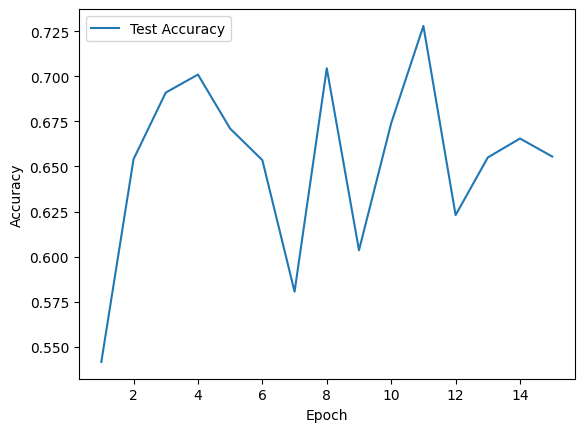

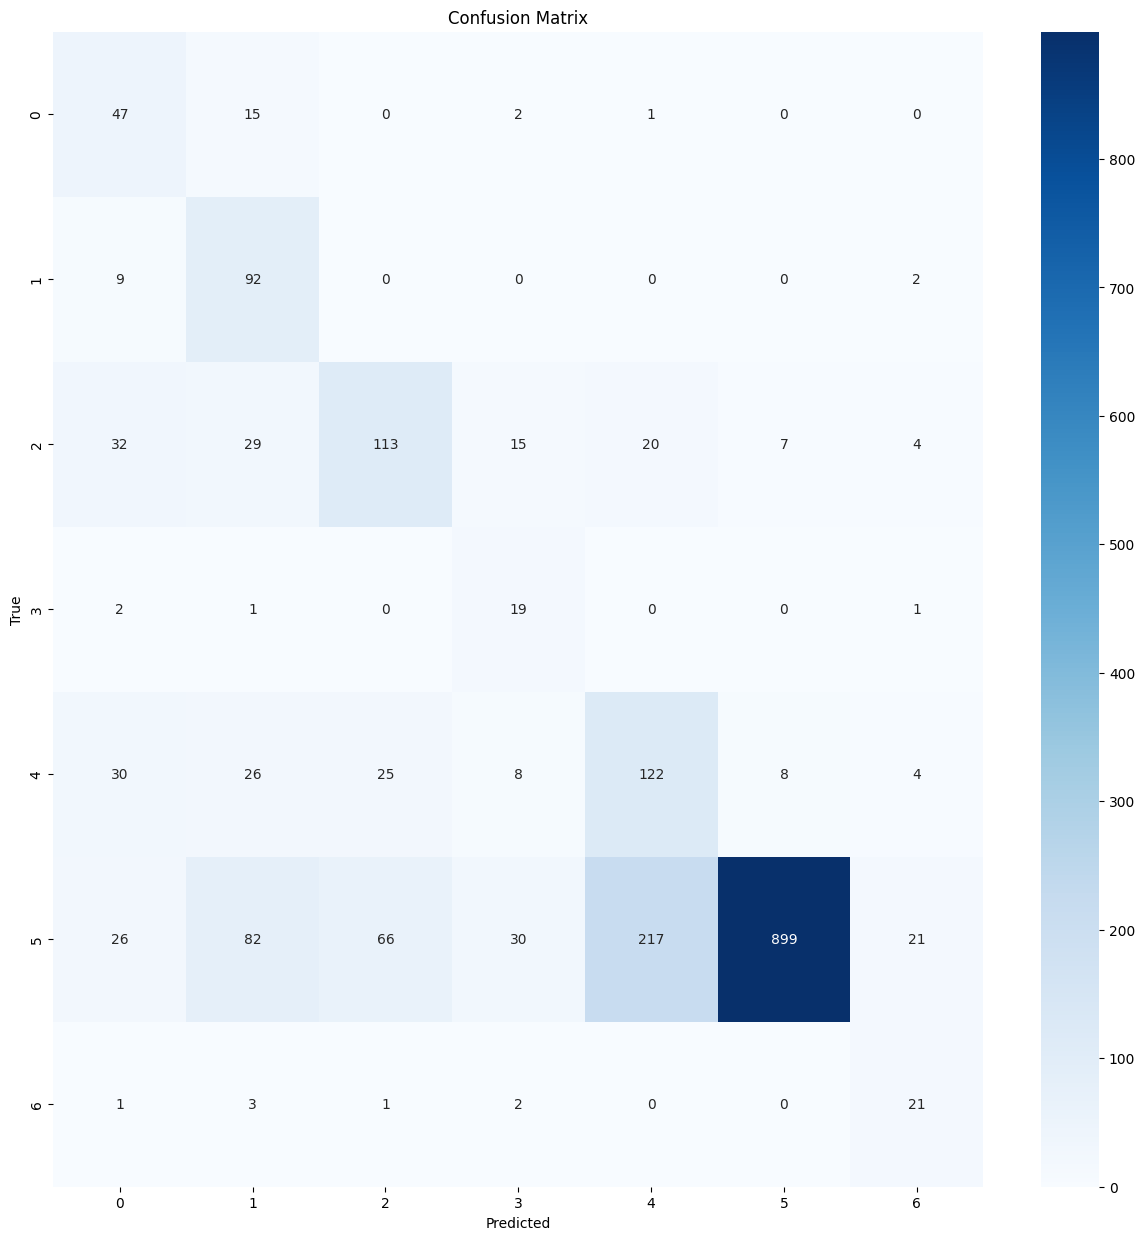

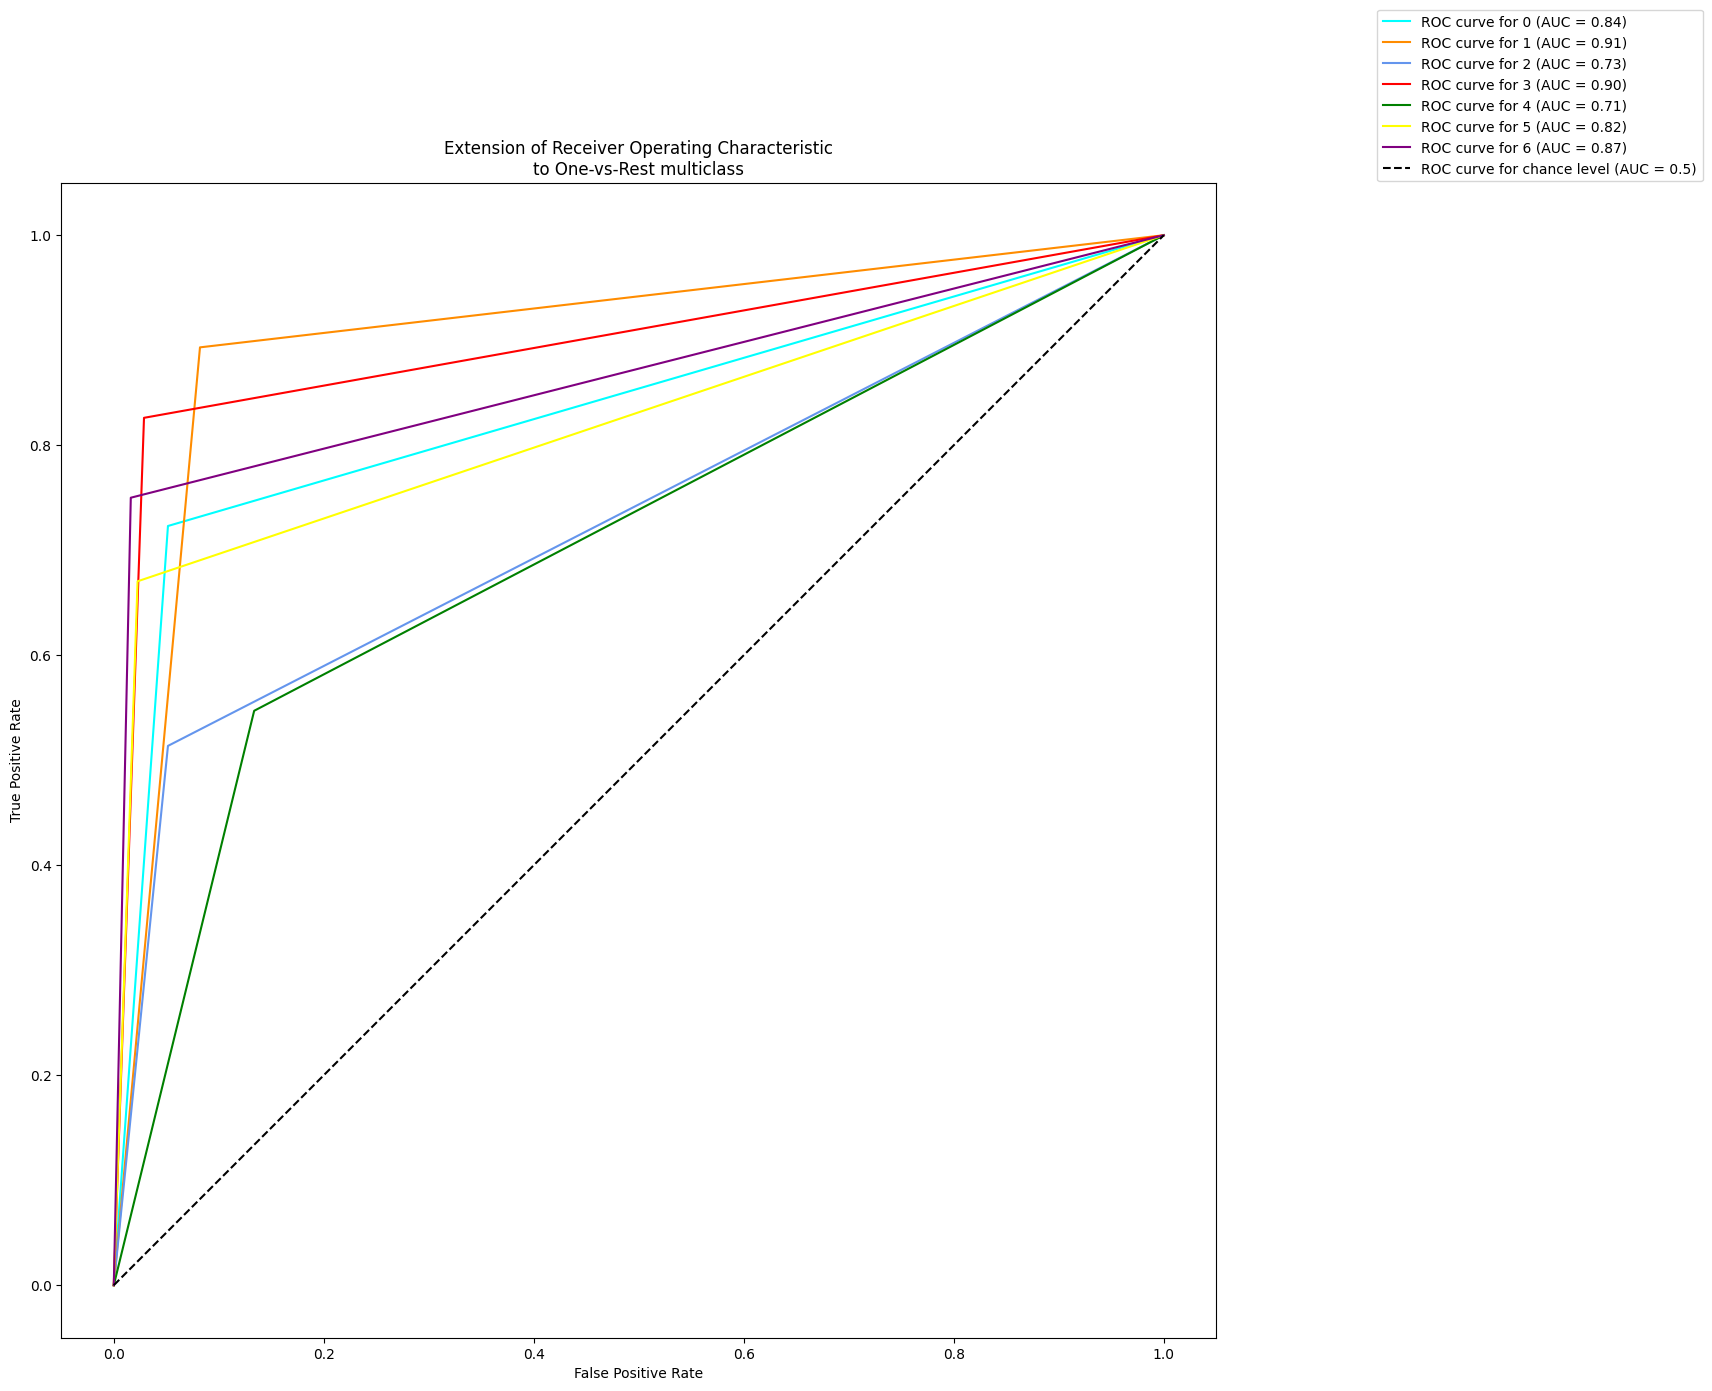

              precision    recall  f1-score   support

           0       0.32      0.72      0.44        65
           1       0.37      0.89      0.52       103
           2       0.55      0.51      0.53       220
           3       0.25      0.83      0.38        23
           4       0.34      0.55      0.42       223
           5       0.98      0.67      0.80      1341
           6       0.40      0.75      0.52        28

    accuracy                           0.66      2003
   macro avg       0.46      0.70      0.52      2003
weighted avg       0.79      0.66      0.69      2003



In [10]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, output_size, num_epochs=15, multilabel=multilabel, report=True, lr=0.001, freeze_backbone=True)

Training Late Fusion Model:
The number of parameters of the model are: 99591
Epoch 1/15 - Test Accuracy: 0.5542
Epoch 1/15 - Training Time: 263.45 seconds | Inference Time: 65.93 seconds
Epoch 2/15 - Test Accuracy: 0.6086
Epoch 2/15 - Training Time: 246.65 seconds | Inference Time: 63.33 seconds
Epoch 3/15 - Test Accuracy: 0.5936
Epoch 3/15 - Training Time: 266.47 seconds | Inference Time: 64.50 seconds
Epoch 4/15 - Test Accuracy: 0.6975
Epoch 4/15 - Training Time: 254.89 seconds | Inference Time: 65.31 seconds
Epoch 5/15 - Test Accuracy: 0.6600
Epoch 5/15 - Training Time: 261.46 seconds | Inference Time: 64.70 seconds
Epoch 6/15 - Test Accuracy: 0.6860
Epoch 6/15 - Training Time: 260.23 seconds | Inference Time: 66.36 seconds
Epoch 7/15 - Test Accuracy: 0.6670
Epoch 7/15 - Training Time: 266.04 seconds | Inference Time: 64.82 seconds
Epoch 8/15 - Test Accuracy: 0.6870
Epoch 8/15 - Training Time: 261.84 seconds | Inference Time: 66.47 seconds
Epoch 9/15 - Test Accuracy: 0.6281
Epoch 9/

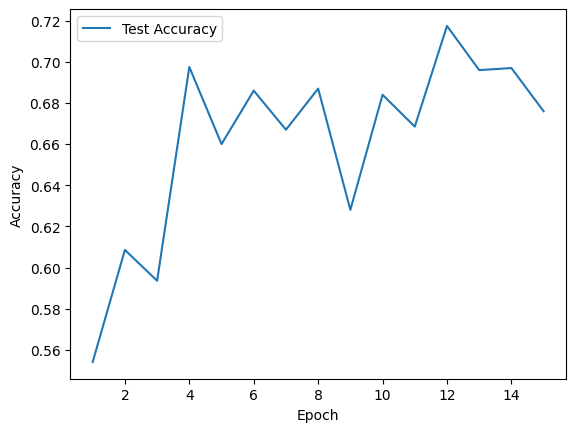

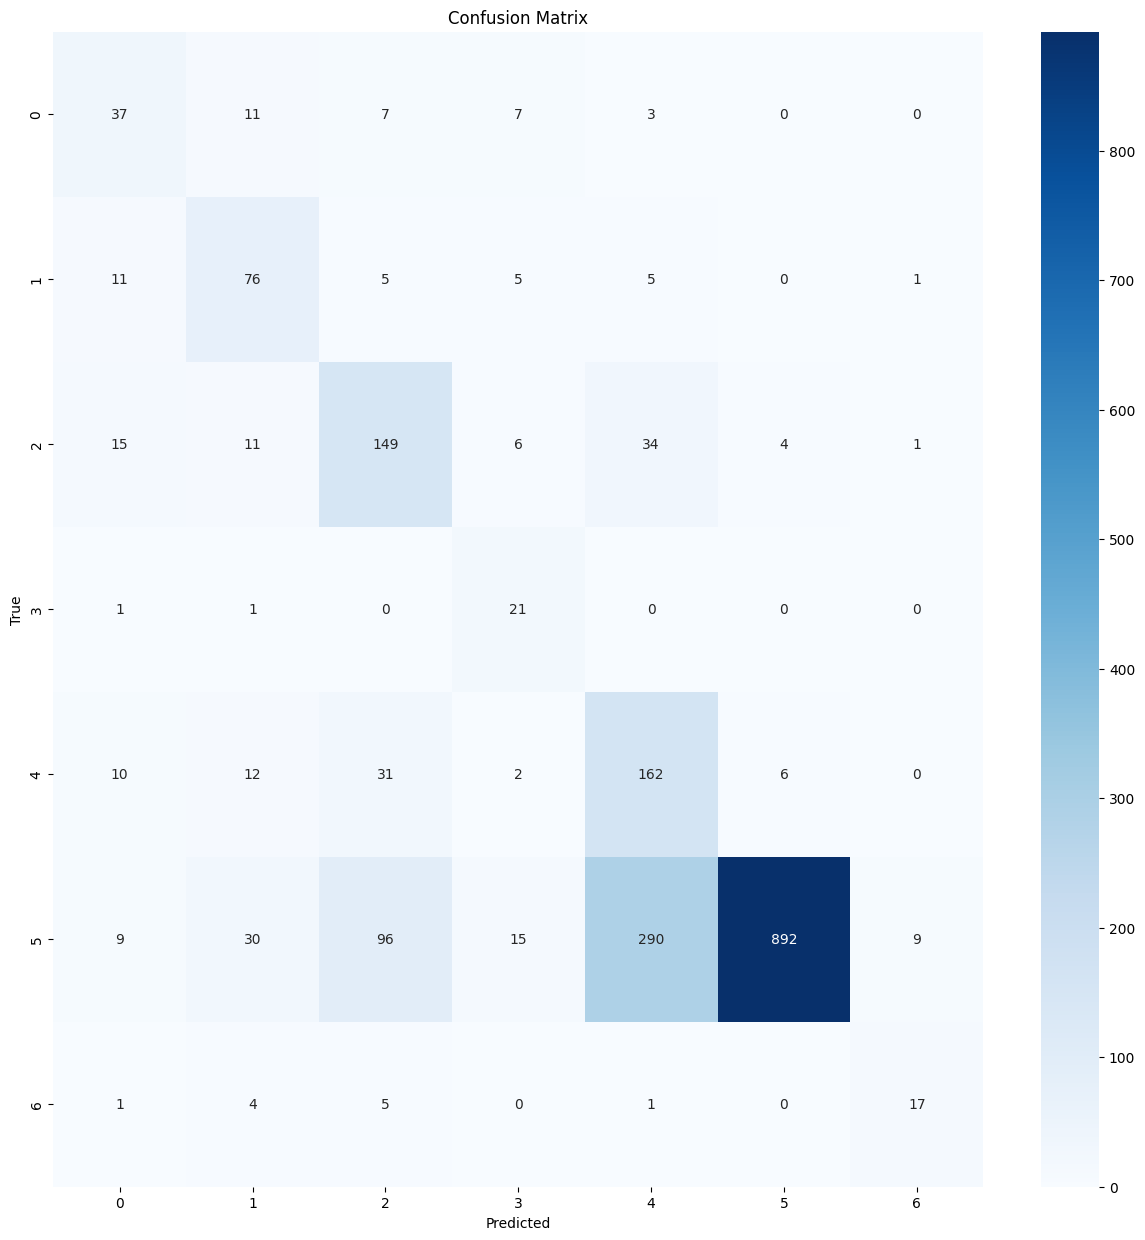

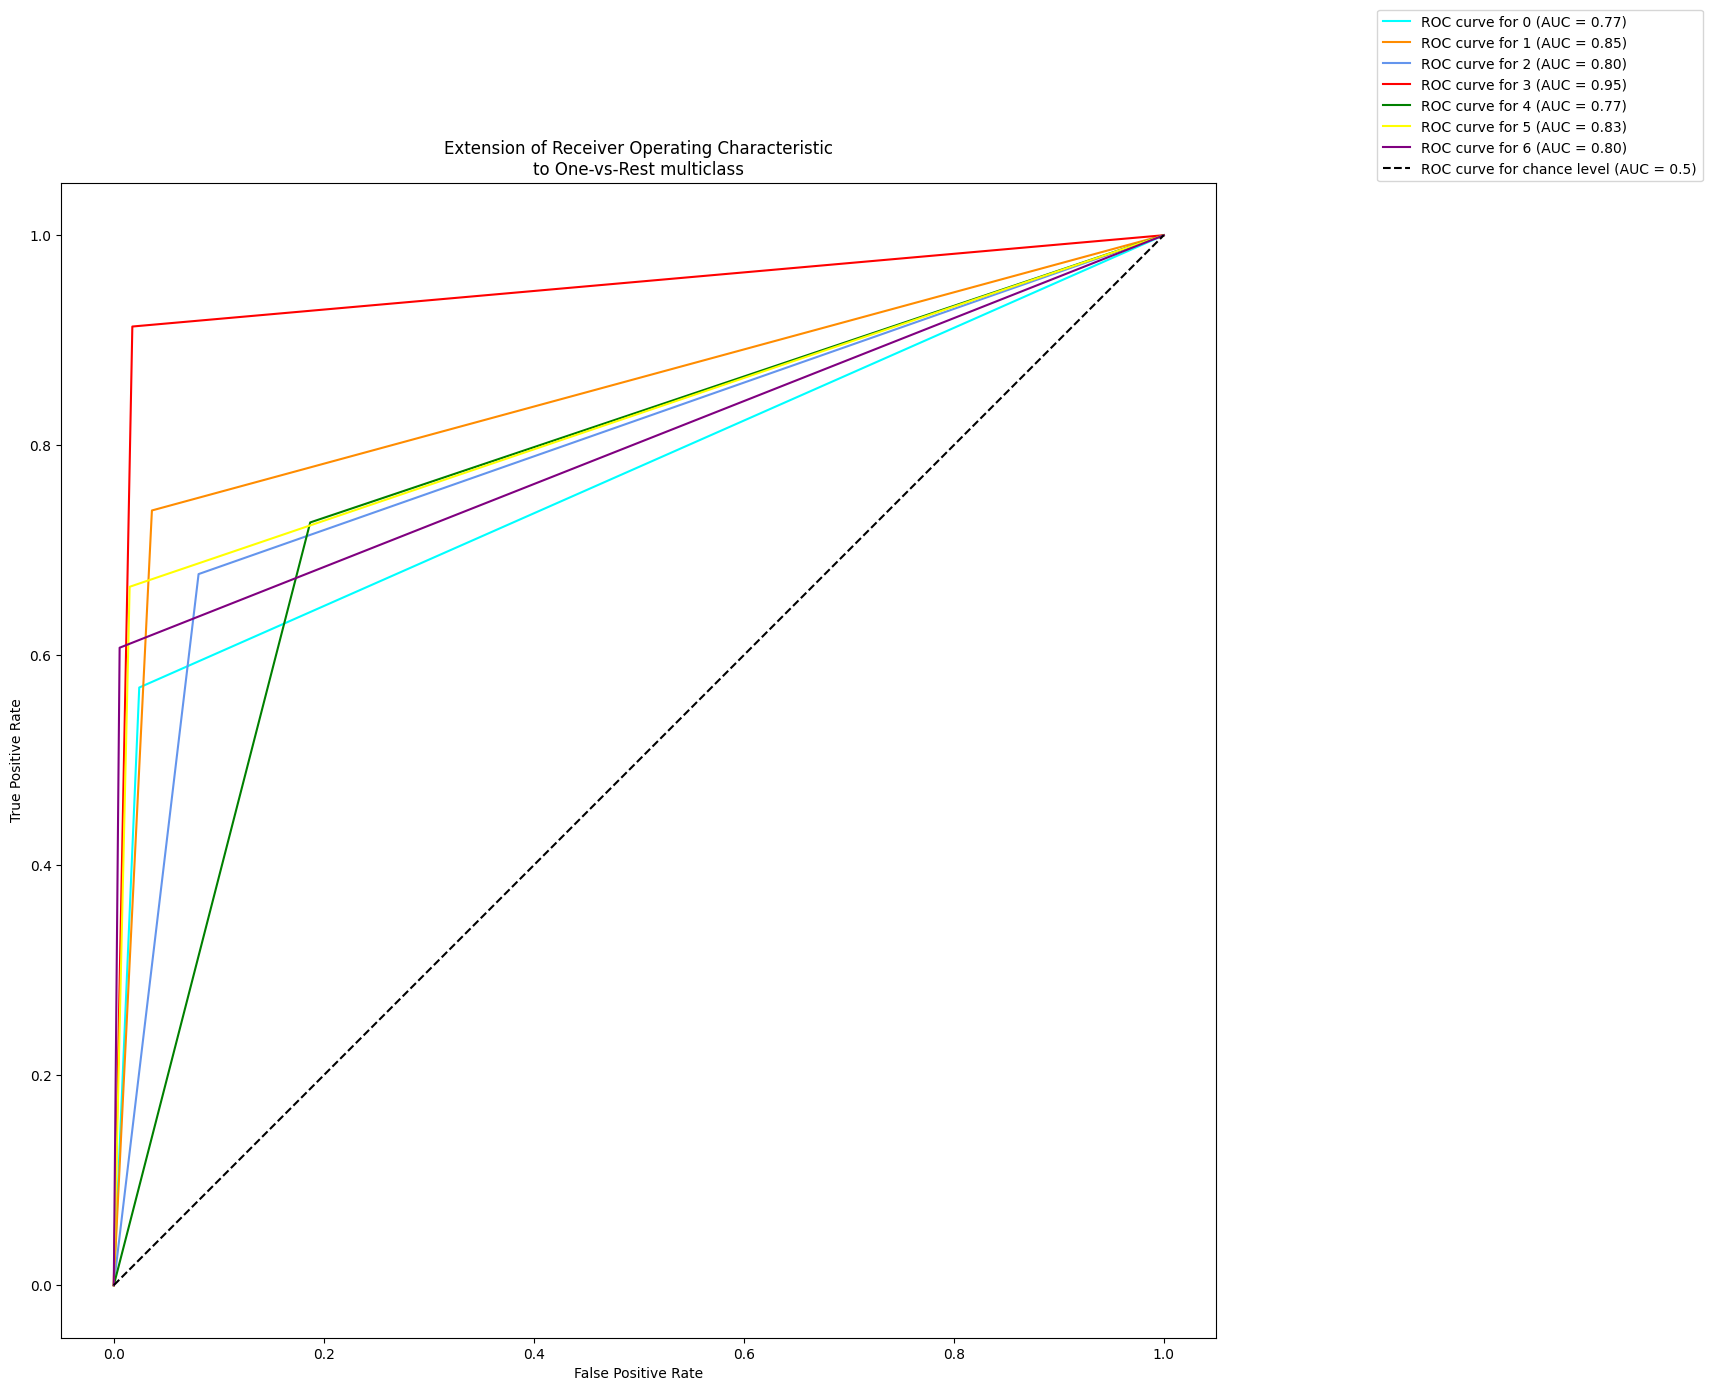

              precision    recall  f1-score   support

           0       0.44      0.57      0.50        65
           1       0.52      0.74      0.61       103
           2       0.51      0.68      0.58       220
           3       0.38      0.91      0.53        23
           4       0.33      0.73      0.45       223
           5       0.99      0.67      0.80      1341
           6       0.61      0.61      0.61        28

    accuracy                           0.68      2003
   macro avg       0.54      0.70      0.58      2003
weighted avg       0.81      0.68      0.71      2003



In [11]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, output_size, num_epochs=15, multilabel=multilabel, report=True, freeze_backbone=True)